In [1]:
from torch.utils.data import Dataset, DataLoader

from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms as T

from adabelief_pytorch import AdaBelief

from torchvision.utils import make_grid

import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import random
import pickle

from scripts.unet import UNet
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, n_classes=53, wf=5, depth=4, padding=True, up_mode='upsample').to(device).eval()

model.load_state_dict(torch.load(f'../results/unet_150_comp_large.pt'))

<All keys matched successfully>

In [3]:
class CardDataset(Dataset):
    def __init__(self, path):
        self._dataset = pickle.load(open(path,'rb'))
        self._images = self._dataset["data"]
        self._gt = self._dataset["gt"]
        self._info = self._dataset["info"]
        
    def __len__(self):
        return len(self._images)
    
    def __getitem__(self, idx):
        im = Image.fromarray(self._images[idx])
        self.trans = T.Compose([
            T.ToTensor()
        ])
        im_t = self.trans(im)
        return im_t, torch.tensor(self._gt[idx])

In [4]:
dataset = CardDataset("../data/PCSE/release/scenes/scenes.pck")
test = CardDataset("../data/PCSE/release/scenes/scenes_test.pck")
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, pin_memory=True)

In [5]:
ious = []
for inp, mask in test:
    res = model(inp.float().reshape(1, 3, 256, 256).to(device))

    out_max = torch.argmax(res, dim=1, keepdim=True).detach().cpu()[0][0]
    intersection = np.logical_and(mask, out_max)
    union = np.logical_or(mask, out_max.detach().cpu()[0][0])
    iou_score = np.sum(intersection.numpy()) / np.sum(union.numpy())
    ious.append(iou_score)

In [6]:
np.mean(ious)

0.9763641015565756

In [13]:
trans = T.Compose([
    T.Resize((256, 256)),
    T.Pad(128),
    T.Resize((256, 256)),
    T.ToTensor()
])

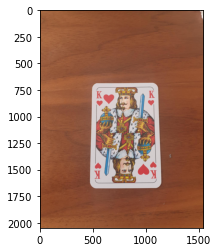

In [22]:
img = Image.open("../data/PCSE/data/decks/deck_skat/H_K.jpeg")
plt.imshow(img)

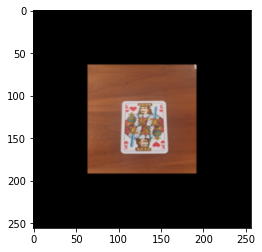

In [23]:
inp = trans(img)
plt.imshow(inp.permute(1,2,0))

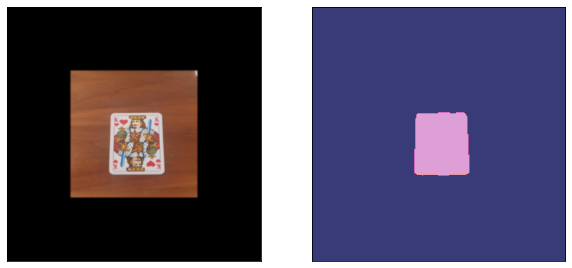

In [24]:
res = model(inp.float().reshape(1, 3, 256, 256).to(device))

out_max = torch.argmax(res, dim=1, keepdim=True)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(inp.permute(1,2,0))
ax[0].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

ax[1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax[1].imshow(out_max.detach().cpu()[0][0], cmap="tab20b")

In [20]:
c = torch.bincount(out_max[0][0].flatten())

In [21]:
torch.topk(c, 4)

torch.return_types.topk(
values=tensor([64429,   424,   377,   255], device='cuda:0'),
indices=tensor([ 0, 24, 11, 25], device='cuda:0'))

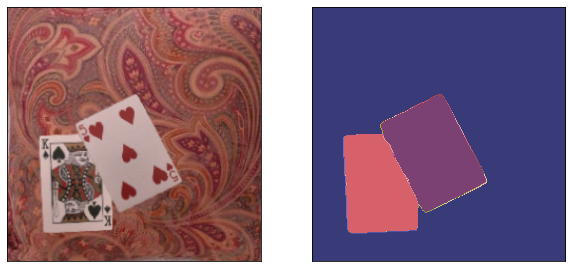

In [25]:
inp, mask = test[420]
img = inp.permute(1, 2, 0)
res = model(inp.float().reshape(1, 3, 256, 256).to(device))

out_max = torch.argmax(res, dim=1, keepdim=True)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(img)
ax[0].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax[1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax[1].imshow(out_max.detach().cpu()[0][0], cmap="tab20b")

In [26]:
inp = test[232][0].float().reshape(1, 3, 256, 256).to(device)
inp.requires_grad = True

res = model(inp)

out_max = torch.argmax(res, dim=1, keepdim=True)

from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution
from captum.attr import visualization as viz

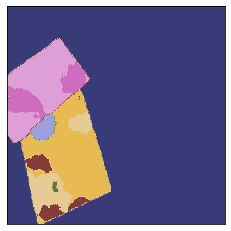

In [27]:
plt.imshow(out_max.cpu()[0][0], cmap="tab20b")
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

In [28]:
def agg_segmentation_wrapper(inp):
    model_out = model(inp)
    # Creates binary matrix with 1 for original argmax class for each pixel
    # and 0 otherwise. Note that this may change when the input is ablated
    # so we use the original argmax predicted above, out_max.
    selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
    return (model_out * selected_inds).sum(dim=(2,3))

In [29]:
lgc = LayerGradCam(agg_segmentation_wrapper, model.last)
gc_attr = lgc.attribute(inp, target=34)

la = LayerActivation(agg_segmentation_wrapper, model.last)
activation = la.attribute(inp)

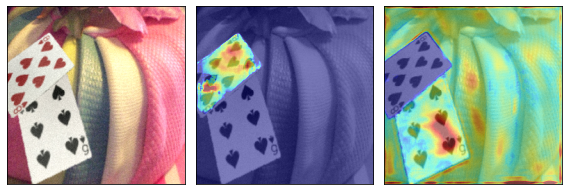

(<Figure size 576x432 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [30]:
upsampled_gc_attr = LayerAttribution.interpolate(gc_attr,inp.shape[2:])
viz.visualize_image_attr_multiple(upsampled_gc_attr[0].cpu().permute(1,2,0).detach().numpy(),original_image=inp[0].cpu().detach().permute(1,2,0).numpy(),signs=["all", "positive", "negative"],methods=["original_image", "blended_heat_map","blended_heat_map"], cmap="jet")

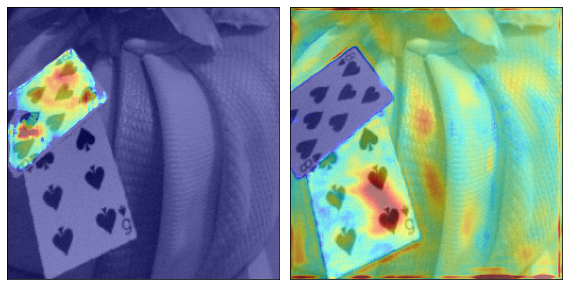

(<Figure size 576x432 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [31]:
upsampled_gc_attr = LayerAttribution.interpolate(gc_attr,inp.shape[2:])
viz.visualize_image_attr_multiple(upsampled_gc_attr[0].cpu().permute(1,2,0).detach().numpy(),original_image=inp[0].cpu().detach().permute(1,2,0).numpy(),signs=["positive", "negative"],methods=["blended_heat_map","blended_heat_map"], cmap="jet")